In [1]:
import warnings

# Disable all warnings
warnings.filterwarnings("ignore")

In [2]:
from Datasets.Audiodata import *
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import IPython
import mir_eval
import pandas as pd
import numpy as np

In [87]:
# import zipfile
# from tqdm import tqdm

# zip_path = "Data/train.zip"
# extract_path = "Data/"

# with zipfile.ZipFile(zip_path, 'r') as z:
#     for file in tqdm(z.namelist(), desc="Extracting files"):
#         z.extract(file, extract_path)

In [89]:
dataset = Audiodataset(set='train_small')
print(len(dataset))

50


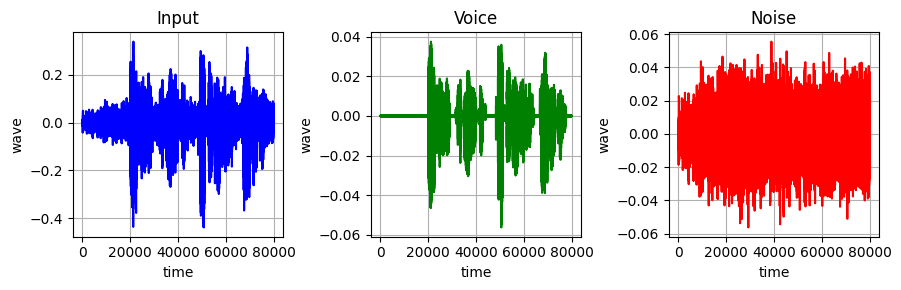

In [90]:
dataset.take_wave()
dataset.plot(0)

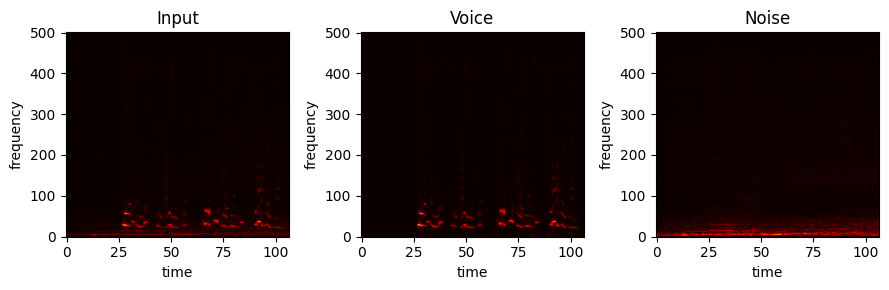

In [91]:
dataset.take_spectrogram()
dataset.plot(0)
plt.savefig('Figs/sp.png')

In [92]:
idx = 2
sr = 8000

test_dataset = Audiodataset('test', padding=True)
test_dataset.return_only_voice()
test_dataset.take_spectrogram()
X, VoiceSP = test_dataset[idx]

reconstruct = test_dataset.reconstruct(VoiceSP, idx, reference='voice')
print(reconstruct.shape)
IPython.display.Audio(reconstruct.squeeze().numpy(), rate=sr)

torch.Size([1, 80000])


In [5]:
from Models.UNet import *
model = UNet().to(device)
from torchsummary import summary
summary(model, input_size = (1,512,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 16, 256, 64]             416
       BatchNorm2d-2          [-1, 16, 256, 64]              32
         LeakyReLU-3          [-1, 16, 256, 64]               0
       EncodeBlock-4          [-1, 16, 256, 64]               0
            Conv2d-5          [-1, 32, 128, 32]          12,832
       BatchNorm2d-6          [-1, 32, 128, 32]              64
         LeakyReLU-7          [-1, 32, 128, 32]               0
       EncodeBlock-8          [-1, 32, 128, 32]               0
            Conv2d-9           [-1, 64, 64, 16]          51,264
      BatchNorm2d-10           [-1, 64, 64, 16]             128
        LeakyReLU-11           [-1, 64, 64, 16]               0
      EncodeBlock-12           [-1, 64, 64, 16]               0
           Conv2d-13           [-1, 128, 32, 8]         204,928
      BatchNorm2d-14           [-1, 128

In [3]:
voice_train_dataset = Audiodataset('train',padding = True,  getitem='voice')
voice_train_dataset.take_spectrogram()

voice_test_dataset = Audiodataset('test', padding = True,getitem='voice')
voice_test_dataset.take_spectrogram()

In [248]:
#voice_model, voice_losses = UNet.trainModel(voice_train_dataset, data_type='Voice', n_epochs=10, batch_size=16, learning_rate=0.001, valid_dataset=voice_test_dataset, schedule = True)

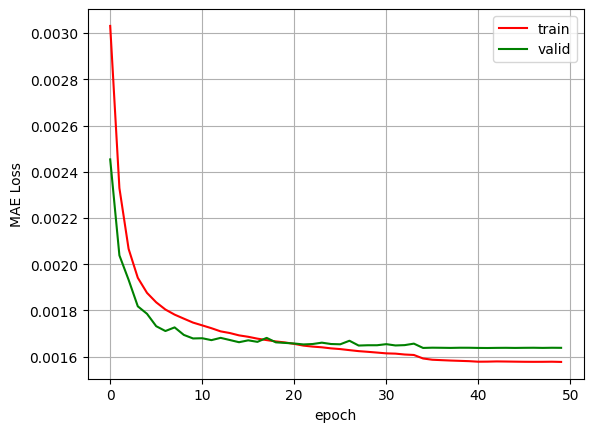

In [252]:
voice_scores_UNet = pd.read_csv('Scores/UNet/Voice/UNetMAE.csv')
voice_train_error = voice_scores_UNet['train']
voice_valid_error = voice_scores_UNet['valid']
plt.plot(voice_train_error, color='red', label='train')
plt.plot(voice_valid_error, color='green', label='valid')
plt.grid()
plt.legend()
plt.xlabel('epoch')
plt.ylabel('MAE Loss')
plt.savefig('Figs/UNet_voice_loss.png')

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
voice_model = UNet().to(device)

# Ensure that the map_location is set to CPU if CUDA is not available
voice_model.load_state_dict(torch.load('Paths/UNet/Voice/model_50.pth', map_location=device))

<All keys matched successfully>

In [240]:
idx = 2
X, Y = voice_test_dataset[idx]
X_ = X.unsqueeze(0).unsqueeze(0).to(device)
output = voice_model(X_)

(512, 128) (512, 128)


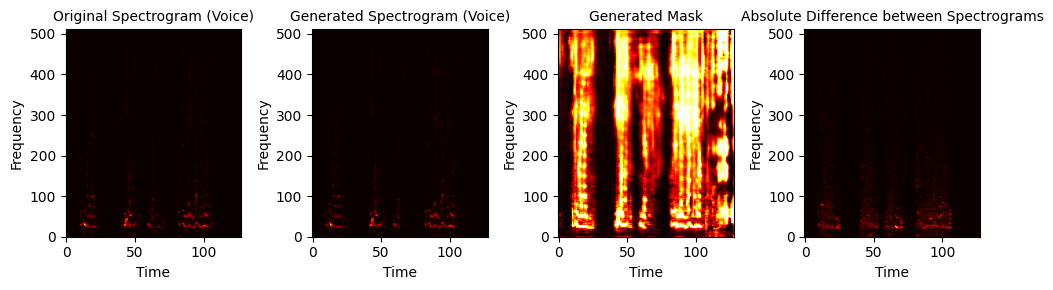

In [254]:
pred = output * X_

Vtrue = Y.detach().cpu().numpy()  # Move to CPU before converting to NumPy
Vpred = (pred).squeeze().detach().cpu().numpy()  # Move to CPU before converting to NumPy
mask = output.squeeze().detach().cpu().numpy()
mix = X.squeeze().detach().cpu().numpy()

print(Vpred.shape, Vtrue.shape)

fig, axs = plt.subplots(1, 4, figsize=(10, 3))

axs[0].imshow(Vtrue, aspect='auto', origin='lower', cmap='hot')
axs[0].set_title('Original Spectrogram (Voice)', fontsize=10)  # Reduce title size
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Frequency')

axs[1].imshow(Vpred, aspect='auto', origin='lower', cmap='hot')
axs[1].set_title('Generated Spectrogram (Voice)', fontsize=10)  # Reduce title size
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Frequency')

axs[2].imshow(mask, aspect='auto', origin='lower', cmap='hot')
axs[2].set_title('Generated Mask', fontsize=10)  # Reduce title size
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Frequency')

axs[3].imshow(np.abs(Vpred - Vtrue), aspect='auto', origin='lower', cmap='hot')
axs[3].set_title('Absolute Difference between Spectrograms', fontsize=10)  # Reduce title size
axs[3].set_xlabel('Time')
axs[3].set_ylabel('Frequency')

plt.tight_layout()
plt.savefig('Figs/UNet_voice_sp.png')
plt.show()


In [255]:
np.sum(np.abs(Vtrue-Vpred))

106.44566

In [256]:
reconstructed_true = voice_test_dataset.reconstruct(Y, id0=idx, reference = 'voice')
IPython.display.Audio(reconstructed_true.detach().numpy(), rate=8000)

In [257]:
reconstructed_output = voice_test_dataset.reconstruct(pred.cpu(), id0=idx, reference='voice')
IPython.display.Audio(reconstructed_output.detach().numpy(), rate=8000)

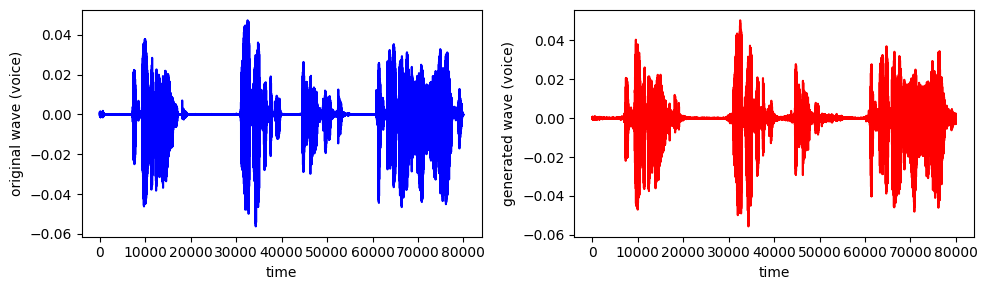

In [258]:
S_true = reconstructed_true.squeeze().detach().numpy()
S_pred = reconstructed_output.squeeze().detach().numpy()
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

axs[0].plot(S_true, color='blue')
axs[0].set_xlabel('time')
axs[0].set_ylabel('original wave (voice)')

axs[1].plot(S_pred, color='red')
axs[1].set_xlabel('time')
axs[1].set_ylabel('generated wave (voice)')
plt.savefig('Figs/UNet_voice_wave.png')

plt.tight_layout()

In [7]:
noise_train_dataset = Audiodataset('train',padding = True,  getitem='noise')
noise_train_dataset.take_spectrogram()

noise_test_dataset = Audiodataset('test', padding = True,getitem='noise')
noise_test_dataset.take_spectrogram()

In [260]:
#noise_model, noise_losses = UNet.trainModel(noise_train_dataset, data_type='Noise', n_epochs=50, batch_size=16, learning_rate=0.001, valid_dataset=noise_test_dataset, schedule = True)

[]


100%|██████████| 313/313 [00:27<00:00, 11.43it/s]

Epoch 1/50 - Train Loss: 0.0075844


Valid Loss: 0.0069467


100%|██████████| 313/313 [00:16<00:00, 18.44it/s]

Epoch 2/50 - Train Loss: 0.0066913


Valid Loss: 0.0064676


100%|██████████| 313/313 [00:16<00:00, 18.73it/s]

Epoch 3/50 - Train Loss: 0.0063349


Valid Loss: 0.0061617


100%|██████████| 313/313 [00:17<00:00, 18.34it/s]

Epoch 4/50 - Train Loss: 0.0061787


Valid Loss: 0.0060490


100%|██████████| 313/313 [00:17<00:00, 18.03it/s]

Epoch 5/50 - Train Loss: 0.0060933


Valid Loss: 0.0059810


100%|██████████| 313/313 [00:16<00:00, 18.82it/s]

Epoch 6/50 - Train Loss: 0.0060446


Valid Loss: 0.0059540


100%|██████████| 313/313 [00:17<00:00, 18.15it/s]

Epoch 7/50 - Train Loss: 0.0060140


Valid Loss: 0.0059216


100%|██████████| 313/313 [00:17<00:00, 17.92it/s]

Epoch 8/50 - Train Loss: 0.0059901


Valid Loss: 0.0059427


100%|██████████| 313/313 [00:16<00:00, 18.62it/s]

Epoch 9/50 - Train Loss: 0.0059729


Valid Loss: 0.0058963


100%|██████████| 313/313 [00:16<00:00, 18.44it/s]

Epoch 10/50 - Train Loss: 0.0059480


Valid Loss: 0.0058901


100%|██████████| 313/313 [00:17<00:00, 18.03it/s]

Epoch 11/50 - Train Loss: 0.0059442


Valid Loss: 0.0058731


100%|██████████| 313/313 [00:17<00:00, 18.34it/s]

Epoch 12/50 - Train Loss: 0.0059243


Valid Loss: 0.0058729


100%|██████████| 313/313 [00:16<00:00, 18.71it/s]

Epoch 13/50 - Train Loss: 0.0059150


Valid Loss: 0.0058725


100%|██████████| 313/313 [00:16<00:00, 18.65it/s]


Epoch 14/50 - Train Loss: 0.0059093
Valid Loss: 0.0058714


100%|██████████| 313/313 [00:17<00:00, 18.10it/s]

Epoch 15/50 - Train Loss: 0.0058978


Valid Loss: 0.0058572


100%|██████████| 313/313 [00:17<00:00, 18.09it/s]

Epoch 16/50 - Train Loss: 0.0058922


Valid Loss: 0.0058546


100%|██████████| 313/313 [00:17<00:00, 18.33it/s]

Epoch 17/50 - Train Loss: 0.0058877


Valid Loss: 0.0058472


100%|██████████| 313/313 [00:17<00:00, 18.08it/s]

Epoch 18/50 - Train Loss: 0.0058839


Valid Loss: 0.0058475


100%|██████████| 313/313 [00:17<00:00, 18.10it/s]

Epoch 19/50 - Train Loss: 0.0058772


Valid Loss: 0.0059369


100%|██████████| 313/313 [00:17<00:00, 18.07it/s]

Epoch 20/50 - Train Loss: 0.0058764


Valid Loss: 0.0059694


100%|██████████| 313/313 [00:16<00:00, 18.53it/s]

Epoch 21/50 - Train Loss: 0.0058722


Valid Loss: 0.0058557


100%|██████████| 313/313 [00:17<00:00, 18.06it/s]

Epoch 22/50 - Train Loss: 0.0058656


Valid Loss: 0.0058457


100%|██████████| 313/313 [00:17<00:00, 17.80it/s]

Epoch 23/50 - Train Loss: 0.0058624


Valid Loss: 0.0058569


100%|██████████| 313/313 [00:16<00:00, 18.53it/s]

Epoch 24/50 - Train Loss: 0.0058566


Valid Loss: 0.0058396


100%|██████████| 313/313 [00:16<00:00, 18.52it/s]

Epoch 25/50 - Train Loss: 0.0058544


Valid Loss: 0.0058935


100%|██████████| 313/313 [00:17<00:00, 17.87it/s]

Epoch 26/50 - Train Loss: 0.0058528


Valid Loss: 0.0058399


100%|██████████| 313/313 [00:17<00:00, 18.14it/s]

Epoch 27/50 - Train Loss: 0.0058477


Valid Loss: 0.0058506


100%|██████████| 313/313 [00:17<00:00, 18.40it/s]

Epoch 28/50 - Train Loss: 0.0058497


Valid Loss: 0.0058562


100%|██████████| 313/313 [00:17<00:00, 17.70it/s]

Epoch 29/50 - Train Loss: 0.0058396


Valid Loss: 0.0058339


100%|██████████| 313/313 [00:17<00:00, 18.01it/s]

Epoch 30/50 - Train Loss: 0.0058375


Valid Loss: 0.0058522


100%|██████████| 313/313 [00:17<00:00, 17.96it/s]

Epoch 31/50 - Train Loss: 0.0058370


Valid Loss: 0.0058589


100%|██████████| 313/313 [00:16<00:00, 18.69it/s]

Epoch 32/50 - Train Loss: 0.0058367


Valid Loss: 0.0058356


100%|██████████| 313/313 [00:17<00:00, 18.02it/s]

Epoch 33/50 - Train Loss: 0.0058343


Valid Loss: 0.0058420


100%|██████████| 313/313 [00:17<00:00, 18.31it/s]

Epoch 34/50 - Train Loss: 0.0058306


Valid Loss: 0.0058319


100%|██████████| 313/313 [00:16<00:00, 18.54it/s]

Epoch 35/50 - Train Loss: 0.0058300


Valid Loss: 0.0058366


100%|██████████| 313/313 [00:17<00:00, 18.34it/s]

Epoch 36/50 - Train Loss: 0.0058254


Valid Loss: 0.0058579


100%|██████████| 313/313 [00:17<00:00, 17.90it/s]

Epoch 37/50 - Train Loss: 0.0058278


Valid Loss: 0.0058283


100%|██████████| 313/313 [00:17<00:00, 17.76it/s]

Epoch 38/50 - Train Loss: 0.0058221


Valid Loss: 0.0058290


100%|██████████| 313/313 [00:16<00:00, 18.43it/s]

Epoch 39/50 - Train Loss: 0.0058244


Valid Loss: 0.0058496


100%|██████████| 313/313 [00:17<00:00, 18.40it/s]

Epoch 40/50 - Train Loss: 0.0058254


Valid Loss: 0.0058323


100%|██████████| 313/313 [00:17<00:00, 17.82it/s]

Epoch 41/50 - Train Loss: 0.0058257


Valid Loss: 0.0058291


100%|██████████| 313/313 [00:17<00:00, 17.95it/s]

Epoch 42/50 - Train Loss: 0.0058191


Valid Loss: 0.0058276


100%|██████████| 313/313 [00:16<00:00, 18.43it/s]

Epoch 43/50 - Train Loss: 0.0058164


Valid Loss: 0.0058271


100%|██████████| 313/313 [00:17<00:00, 18.05it/s]

Epoch 44/50 - Train Loss: 0.0058157


Valid Loss: 0.0058308


100%|██████████| 313/313 [00:17<00:00, 17.95it/s]

Epoch 45/50 - Train Loss: 0.0058137


Valid Loss: 0.0058251


100%|██████████| 313/313 [00:17<00:00, 18.16it/s]

Epoch 46/50 - Train Loss: 0.0058148


Valid Loss: 0.0058264


100%|██████████| 313/313 [00:16<00:00, 18.53it/s]

Epoch 47/50 - Train Loss: 0.0058132


Valid Loss: 0.0058262


100%|██████████| 313/313 [00:17<00:00, 17.97it/s]

Epoch 48/50 - Train Loss: 0.0058084


Valid Loss: 0.0058252


100%|██████████| 313/313 [00:17<00:00, 18.08it/s]

Epoch 49/50 - Train Loss: 0.0058081


Valid Loss: 0.0058266


100%|██████████| 313/313 [00:17<00:00, 18.37it/s]

Epoch 50/50 - Train Loss: 0.0058113


Valid Loss: 0.0058286


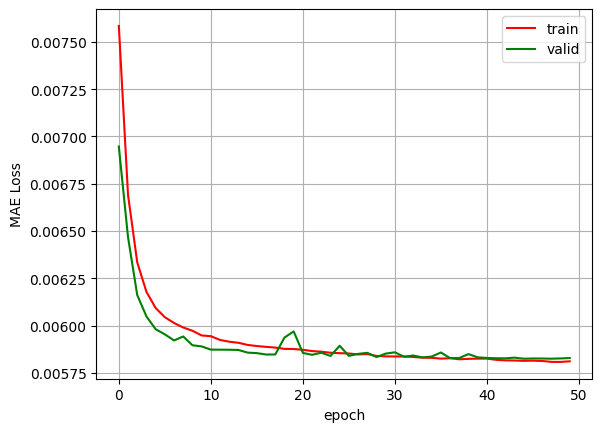

In [262]:
noise_scores_UNet = pd.read_csv('Scores/UNet/Noise/UNetMAE.csv')
noise_train_error = noise_scores_UNet['train']
noise_valid_error = noise_scores_UNet['valid']
plt.plot(noise_train_error, color='red', label='train')
plt.plot(noise_valid_error, color='green', label='valid')
plt.grid()
plt.legend()
plt.xlabel('epoch')
plt.ylabel('MAE Loss')
plt.savefig('Figs/UNet_noise_loss.png')

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
noise_model = UNet().to(device)

# Ensure that the map_location is set to CPU if CUDA is not available
noise_model.load_state_dict(torch.load('Paths/UNet/Noise/model_50.pth', map_location=device))

<All keys matched successfully>

In [264]:
idx = 100
X, Y = noise_test_dataset[idx]
X_ = X.unsqueeze(0).unsqueeze(0).to(device)
output = noise_model(X_)

(512, 128) (512, 128)


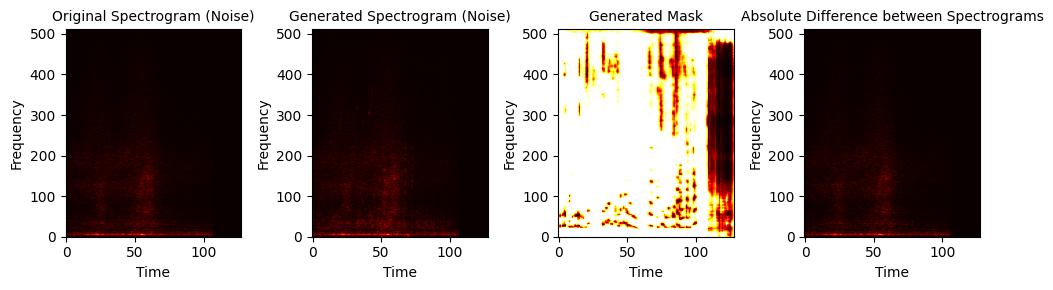

In [265]:

pred = output * X_

Vtrue = Y.detach().cpu().numpy()  # Move to CPU before converting to NumPy
Vpred = (pred).squeeze().detach().cpu().numpy()  # Move to CPU before converting to NumPy
mask = output.squeeze().detach().cpu().numpy()

print(Vpred.shape, Vtrue.shape)

fig, axs = plt.subplots(1, 4, figsize=(10, 3))

axs[0].imshow(Vtrue, aspect='auto', origin='lower', cmap='hot')
axs[0].set_title('Original Spectrogram (Noise)', fontsize=10)  # Reduce title size
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Frequency')

axs[1].imshow(Vpred, aspect='auto', origin='lower', cmap='hot')
axs[1].set_title('Generated Spectrogram (Noise)', fontsize=10)  # Reduce title size
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Frequency')

axs[2].imshow(mask, aspect='auto', origin='lower', cmap='hot')
axs[2].set_title('Generated Mask', fontsize=10)  # Reduce title size
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Frequency')

axs[3].imshow(np.abs(Vpred - Vtrue), aspect='auto', origin='lower', cmap='hot')
axs[3].set_title('Absolute Difference between Spectrograms', fontsize=10)  # Reduce title size
axs[3].set_xlabel('Time')
axs[3].set_ylabel('Frequency')

plt.tight_layout()
plt.savefig('Figs/UNet_noise_sp.png')

plt.show()


In [9]:
np.sum(np.abs(Vtrue-Vpred))

NameError: name 'Vtrue' is not defined

In [267]:
reconstructed_true = noise_test_dataset.reconstruct(Y, id0=idx, reference = 'noise')
IPython.display.Audio(reconstructed_true.detach().numpy(), rate=8000)

In [268]:
reconstructed_output = noise_test_dataset.reconstruct(pred.cpu(), id0=idx, reference='noise')
IPython.display.Audio(reconstructed_output.detach().numpy(), rate=8000)

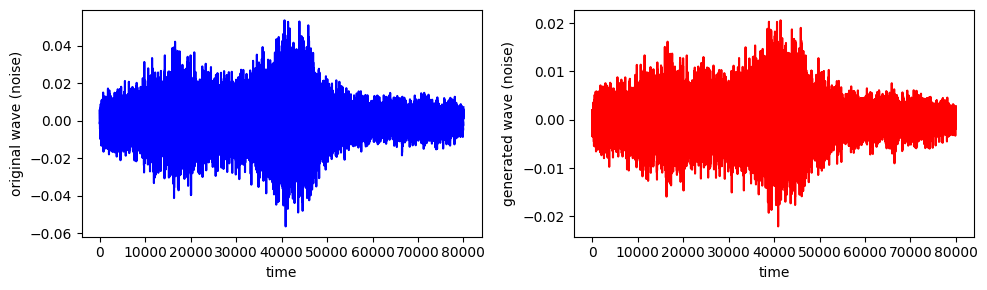

In [269]:
S_true = reconstructed_true.squeeze().detach().numpy()
S_pred = reconstructed_output.squeeze().detach().numpy()
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

axs[0].plot(S_true, color='blue')
axs[0].set_xlabel('time')
axs[0].set_ylabel('original wave (noise)')

axs[1].plot(S_pred, color='red')
axs[1].set_xlabel('time')
axs[1].set_ylabel('generated wave (noise)')
plt.savefig('Figs/UNet_noise_wave.png')

plt.tight_layout()

In [11]:
test_dataset = Audiodataset('test',padding = True,  getitem='all')
test_dataset.take_spectrogram()

In [12]:
metrics_data = UNet.validateModel(voice_model, noise_model, test_dataset,subset_size=50)

Subsets created


Validation Progress (SNR=1): 100%|██████████| 50/50 [00:34<00:00,  1.46it/s]


In [13]:

metrics_dir = "Scores/UNet/"

metrics_by_snr = {}

# Liste des SNR et des signaux que vous avez enregistrés
snr_values = np.arange(-4,5)  
signals = ['voice', 'noise']  

# Lire les fichiers CSV pour chaque combinaison SNR et Signal
for snr in snr_values:
    metrics_by_snr[snr] = {}  
    for signal in signals:
        # Construire le chemin du fichier correspondant pour ce signal et SNR
        file_path = os.path.join(metrics_dir, f'val_metrics_SNR_{snr}_{signal}.csv')
        if os.path.exists(file_path):
            #print(file_path)
            # Lire le fichier CSV dans un DataFrame
            df = pd.read_csv(file_path)
            
            # Stocker les métriques pour ce signal et SNR
            metrics_by_snr[snr][signal] = df

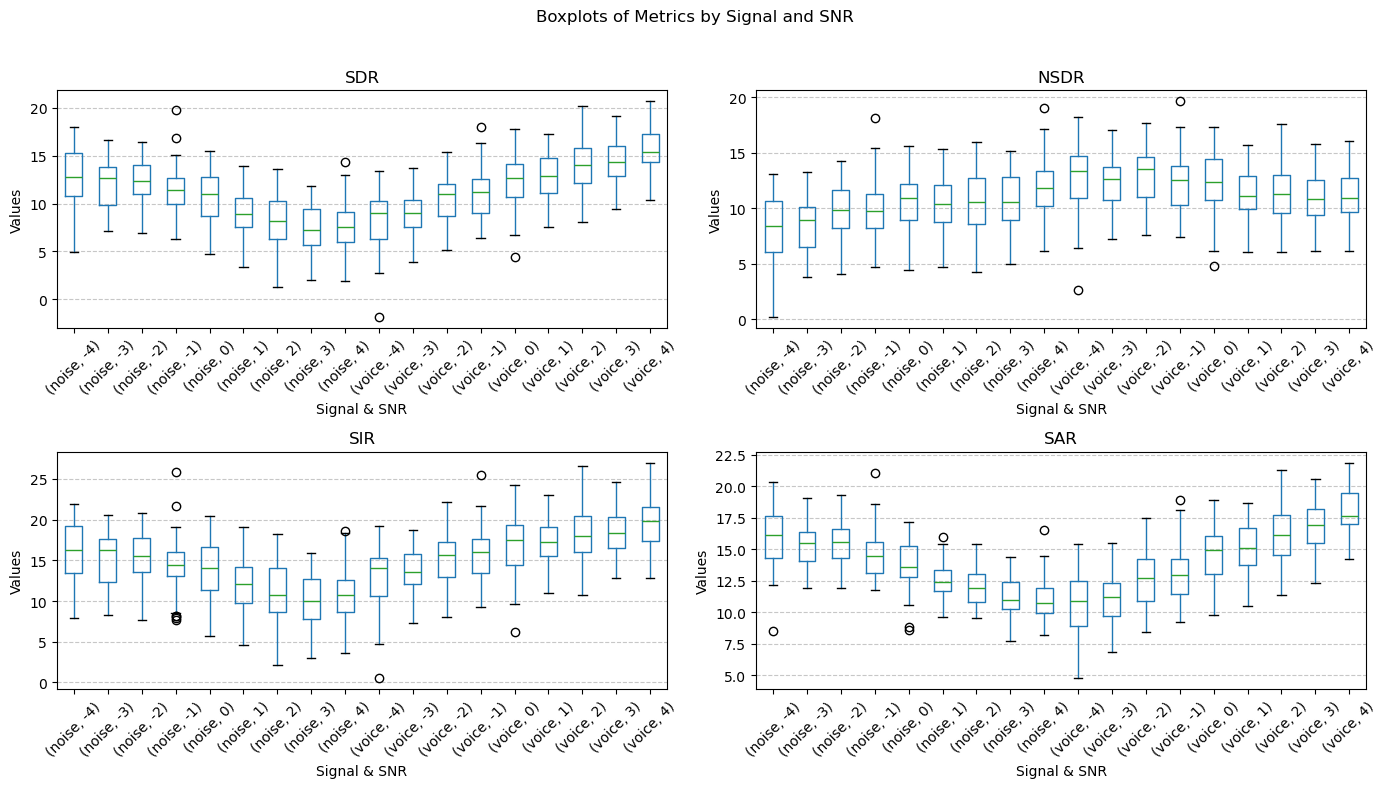

In [14]:
# Combiner les données pour chaque signal et SNR
all_data = []
for snr, metrics in metrics_by_snr.items():
    for signal, df in metrics.items():
        df['SNR'] = snr
        df['Signal'] = signal
        all_data.append(df)

# Créer un DataFrame combiné
combined_df = pd.concat(all_data, ignore_index=True)

# Tracer les boxplots pour chaque métrique
metrics = ['SDR', 'NSDR', 'SIR', 'SAR']
plt.figure(figsize=(14, 8))

for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 2, i)
    combined_df.boxplot(column=metric, by=['Signal', 'SNR'], grid=False, ax=plt.gca())
    plt.title(metric)
    plt.xlabel('Signal & SNR')
    plt.ylabel('Values')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

# Ajouter un titre principal et ajuster la mise en page
plt.suptitle('Boxplots of Metrics by Signal and SNR')
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Sauvegarder le graphique
output_path = 'Figs/UNet_val_metrics.png'
os.makedirs(os.path.dirname(output_path), exist_ok=True)
plt.savefig(output_path)

# Afficher le graphique
plt.show()


In [16]:
from Models.UNet2 import *
model = UNet2().to(device)
from torchsummary import summary
summary(model, input_size = (1,512,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 16, 256, 64]             416
       BatchNorm2d-2          [-1, 16, 256, 64]              32
         LeakyReLU-3          [-1, 16, 256, 64]               0
       EncodeBlock-4          [-1, 16, 256, 64]               0
            Conv2d-5          [-1, 32, 128, 32]          12,832
       BatchNorm2d-6          [-1, 32, 128, 32]              64
         LeakyReLU-7          [-1, 32, 128, 32]               0
       EncodeBlock-8          [-1, 32, 128, 32]               0
            Conv2d-9           [-1, 64, 64, 16]          51,264
      BatchNorm2d-10           [-1, 64, 64, 16]             128
        LeakyReLU-11           [-1, 64, 64, 16]               0
      EncodeBlock-12           [-1, 64, 64, 16]               0
           Conv2d-13           [-1, 128, 32, 8]         204,928
      BatchNorm2d-14           [-1, 128

In [17]:
train_dataset = Audiodataset('train',padding = True,  getitem='all')
train_dataset.take_spectrogram()

test_dataset = Audiodataset('test', padding = True,getitem='all')
test_dataset.take_spectrogram()

In [15]:
#model2, losses2 = UNet2.trainModel(train_dataset, n_epochs=50, batch_size=16, learning_rate=0.001, valid_dataset=test_dataset, schedule = True)

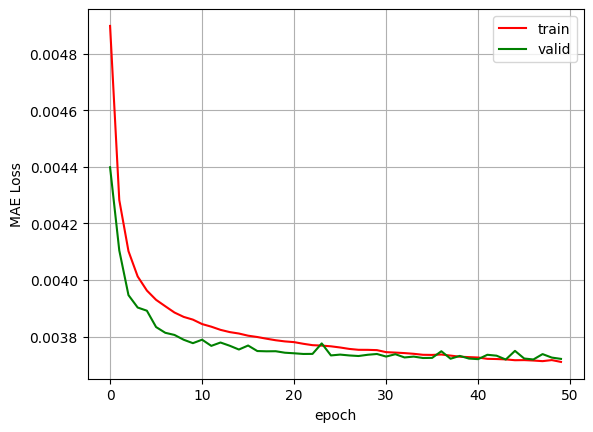

In [299]:
scores_UNet2 = pd.read_csv('Scores/UNet2/UNet2MAE.csv')
train_error = scores_UNet2['train']
valid_error = scores_UNet2['valid']
plt.plot(train_error, color='red', label='train')
plt.plot(valid_error, color='green', label='valid')
plt.grid()
plt.legend()
plt.xlabel('epoch')
plt.ylabel('MAE Loss')
plt.savefig('Figs/UNet2_loss.png')

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model2 = UNet2().to(device)

# Ensure that the map_location is set to CPU if CUDA is not available
model2.load_state_dict(torch.load('Paths/UNet2/model_50.pth', map_location=device))

<All keys matched successfully>

In [301]:
idx = 2
X, voice,noise,_,_ = test_dataset[idx]
X_ = X.unsqueeze(0).unsqueeze(0).to(device)
output = model2(X_).squeeze()

In [302]:
pred = output * X_

Vpred = (pred).squeeze().detach().cpu().numpy()  # Move to CPU before converting to NumPy
mask = output.squeeze().detach().cpu().numpy()
voice_ = voice.squeeze().detach().cpu().numpy()
noise_ = noise.squeeze().detach().cpu().numpy()
print(Vpred.shape, mask.shape)

(2, 512, 128) (2, 512, 128)


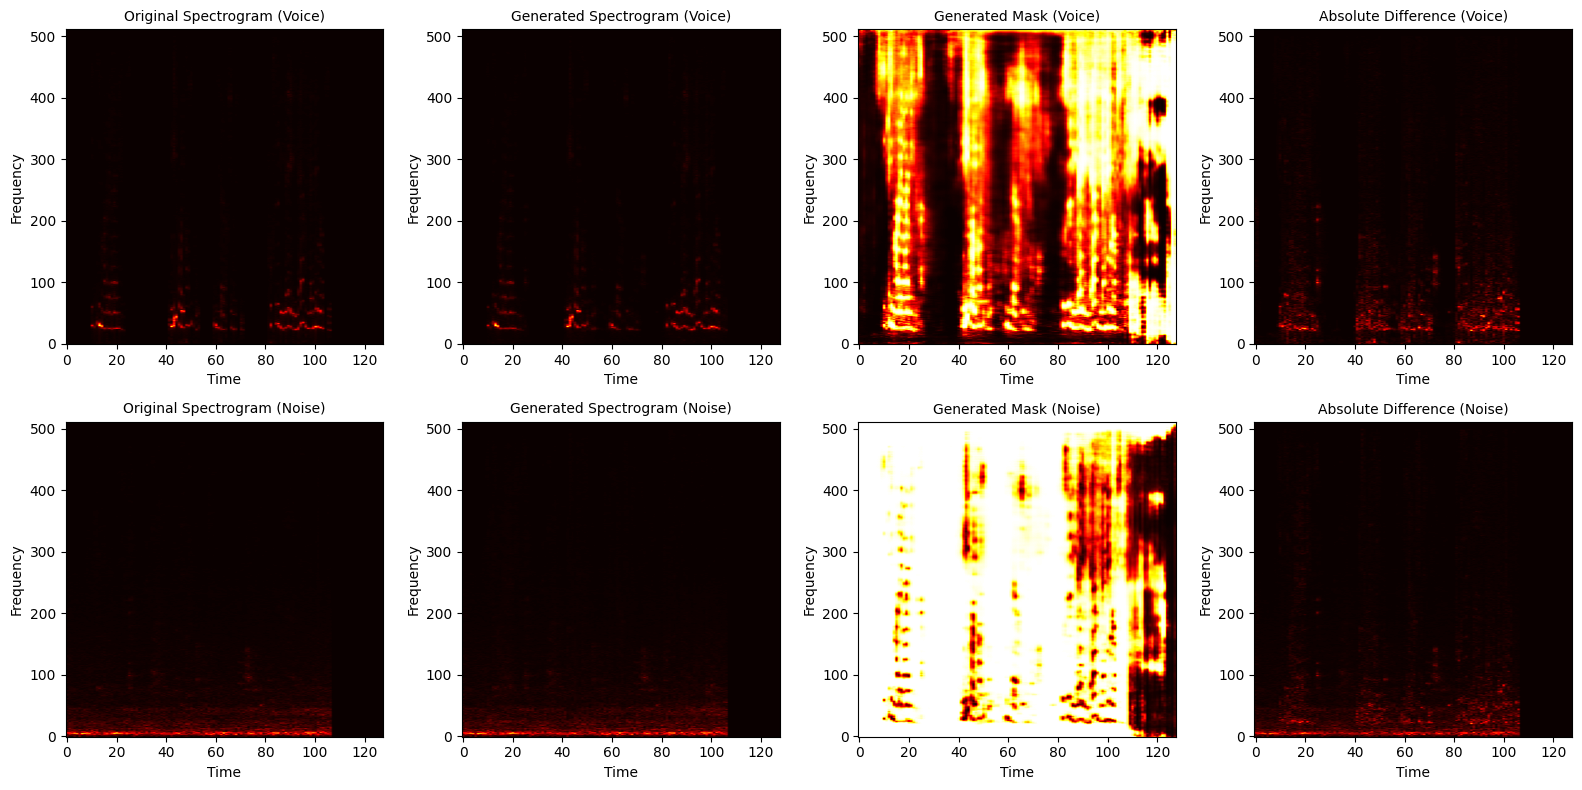

In [303]:
fig, axs = plt.subplots(2, 4, figsize=(16, 8))  # 2 lignes, 4 colonnes, taille ajustée

# Ligne 1 : Voice
# Original Spectrogram (Voice)
axs[0, 0].imshow(voice_, aspect='auto', origin='lower', cmap='hot')
axs[0, 0].set_title('Original Spectrogram (Voice)', fontsize=10)
axs[0, 0].set_xlabel('Time')
axs[0, 0].set_ylabel('Frequency')

# Generated Spectrogram (Voice)
axs[0, 1].imshow(Vpred[0], aspect='auto', origin='lower', cmap='hot')
axs[0, 1].set_title('Generated Spectrogram (Voice)', fontsize=10)
axs[0, 1].set_xlabel('Time')
axs[0, 1].set_ylabel('Frequency')

# Generated Mask (Voice)
axs[0, 2].imshow(mask[0], aspect='auto', origin='lower', cmap='hot')
axs[0, 2].set_title('Generated Mask (Voice)', fontsize=10)
axs[0, 2].set_xlabel('Time')
axs[0, 2].set_ylabel('Frequency')

# Absolute Difference (Voice)
axs[0, 3].imshow(np.abs(Vpred[0] - voice_), aspect='auto', origin='lower', cmap='hot')
axs[0, 3].set_title('Absolute Difference (Voice)', fontsize=10)
axs[0, 3].set_xlabel('Time')
axs[0, 3].set_ylabel('Frequency')

# Ligne 2 : Noise
# Original Spectrogram (Noise)
axs[1, 0].imshow(noise_, aspect='auto', origin='lower', cmap='hot')
axs[1, 0].set_title('Original Spectrogram (Noise)', fontsize=10)
axs[1, 0].set_xlabel('Time')
axs[1, 0].set_ylabel('Frequency')

# Generated Spectrogram (Noise)
axs[1, 1].imshow(Vpred[1], aspect='auto', origin='lower', cmap='hot')
axs[1, 1].set_title('Generated Spectrogram (Noise)', fontsize=10)
axs[1, 1].set_xlabel('Time')
axs[1, 1].set_ylabel('Frequency')

# Generated Mask (Noise)
axs[1, 2].imshow(mask[1], aspect='auto', origin='lower', cmap='hot')
axs[1, 2].set_title('Generated Mask (Noise)', fontsize=10)
axs[1, 2].set_xlabel('Time')
axs[1, 2].set_ylabel('Frequency')

# Absolute Difference (Noise)
axs[1, 3].imshow(np.abs(Vpred[1] - noise_), aspect='auto', origin='lower', cmap='hot')
axs[1, 3].set_title('Absolute Difference (Noise)', fontsize=10)
axs[1, 3].set_xlabel('Time')
axs[1, 3].set_ylabel('Frequency')

# Ajustements finaux
plt.tight_layout()  # Ajuste les espacements pour éviter les chevauchements
plt.savefig('Figs/UNet2_sp.png')  # Enregistre la figure
plt.show()  # Affiche la figure


In [304]:
print(np.sum(np.abs(Vpred[0] - voice_)),np.sum(np.abs(Vpred[1] - noise_)))

110.91491 197.22705


In [305]:
voice_gt = test_dataset.reconstruct(voice, id0=idx, reference = 'voice')
IPython.display.Audio(voice_gt.detach().numpy(), rate=8000)

In [306]:
voice_est = (pred).squeeze().detach().cpu()[0]
voice_est = test_dataset.reconstruct(voice_est, id0=idx, reference = 'voice')
IPython.display.Audio(voice_est.detach().numpy(), rate=8000)

In [307]:
noise_gt = test_dataset.reconstruct(noise, id0=idx, reference = 'noise')
IPython.display.Audio(noise_gt.numpy(), rate=8000)

In [308]:
noise_est = (pred).squeeze().detach().cpu()[1]
noise_est = test_dataset.reconstruct(noise_est, id0=idx, reference = 'noise')
IPython.display.Audio(noise_est.numpy(), rate=8000)

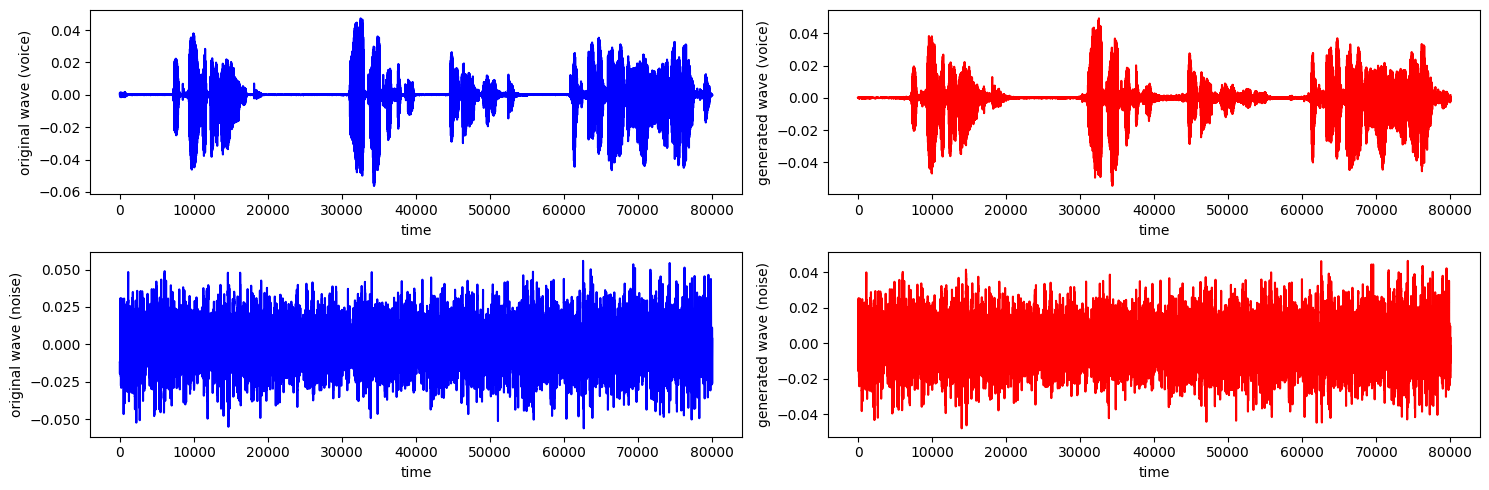

In [309]:
fig, axs = plt.subplots(2, 2, figsize=(15, 5))

axs[0,0].plot(voice_gt.squeeze().numpy(), color='blue')
axs[0,0].set_xlabel('time')
axs[0,0].set_ylabel('original wave (voice)')

axs[0,1].plot(voice_est.squeeze().numpy(), color='red')
axs[0,1].set_xlabel('time')
axs[0,1].set_ylabel('generated wave (voice)')


axs[1,0].plot(noise_gt.squeeze().numpy(), color='blue')
axs[1,0].set_xlabel('time')
axs[1,0].set_ylabel('original wave (noise)')

axs[1,1].plot(noise_est.squeeze().numpy(), color='red')
axs[1,1].set_xlabel('time')
axs[1,1].set_ylabel('generated wave (noise)')
plt.savefig('Figs/UNet2_wave.png')
plt.tight_layout()

In [19]:
metrics_data2 = UNet2.validateModel(model2, test_dataset,subset_size=50)

Subsets created


Validation Progress (SNR=1): 100%|██████████| 50/50 [00:33<00:00,  1.48it/s]


In [20]:
metrics_dir2 = "Scores/UNet2/"

metrics_by_snr2 = {}

# Liste des SNR et des signaux que vous avez enregistrés
snr_values = np.arange(-4,5)  
signals = ['voice', 'noise']  

# Lire les fichiers CSV pour chaque combinaison SNR et Signal
for snr in snr_values:
    metrics_by_snr2[snr] = {}  
    for signal in signals:
        # Construire le chemin du fichier correspondant pour ce signal et SNR
        file_path = os.path.join(metrics_dir, f'val_metrics_SNR_{snr}_{signal}.csv')
        if os.path.exists(file_path):
            #print(file_path)
            # Lire le fichier CSV dans un DataFrame
            df = pd.read_csv(file_path)
            
            # Stocker les métriques pour ce signal et SNR
            metrics_by_snr2[snr][signal] = df


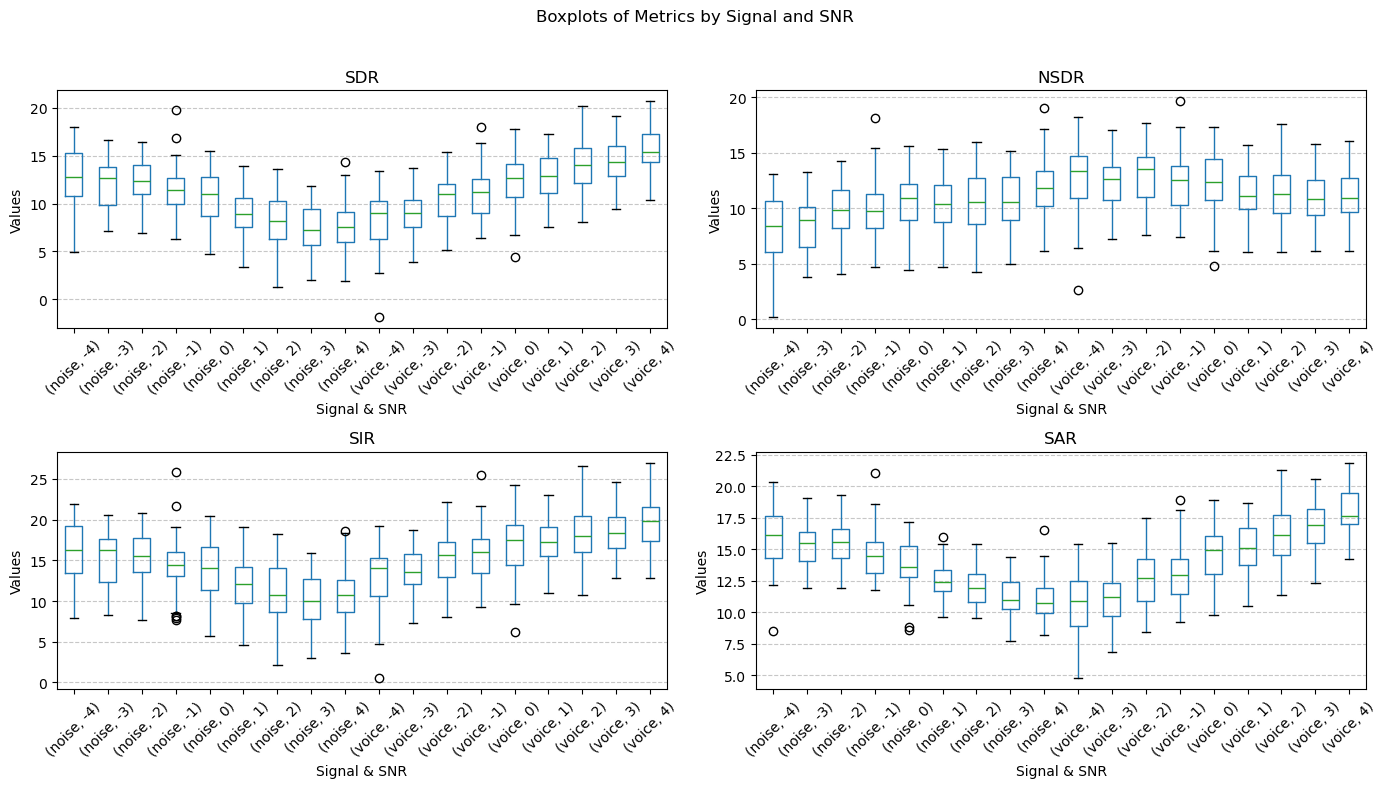

In [21]:
# Combiner les données pour chaque signal et SNR
all_data = []
for snr, metrics in metrics_by_snr2.items():
    for signal, df in metrics.items():
        df['SNR'] = snr
        df['Signal'] = signal
        all_data.append(df)

# Créer un DataFrame combiné
combined_df = pd.concat(all_data, ignore_index=True)

# Tracer les boxplots pour chaque métrique
metrics = ['SDR', 'NSDR', 'SIR', 'SAR']
plt.figure(figsize=(14, 8))

for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 2, i)
    combined_df.boxplot(column=metric, by=['Signal', 'SNR'], grid=False, ax=plt.gca())
    plt.title(metric)
    plt.xlabel('Signal & SNR')
    plt.ylabel('Values')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

# Ajouter un titre principal et ajuster la mise en page
plt.suptitle('Boxplots of Metrics by Signal and SNR')
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Sauvegarder le graphique
output_path = 'Figs/UNet2_val_metrics.png'
os.makedirs(os.path.dirname(output_path), exist_ok=True)
plt.savefig(output_path)

# Afficher le graphique
plt.show()